# Генерация конформаций

In [56]:
import matplotlib.pylab as plt # Для визуализации
import numpy as np # Для работы с массивами
import pandas as pd # Для работы с таблицами
from tqdm import tqdm

In [37]:
from rdkit import Chem
from rdkit.Chem import AllChem # Нужен для построения вектора фингерпринтов
from rdkit.ML.Cluster import Butina # Нужен для кластеризации

from sklearn.model_selection import train_test_split # Нужно для создание тренировочной и тестовой выборки
from xgboost import XGBRegressor 

from sklearn.metrics import mean_squared_error, r2_score # Метрики для регрессий

## Разбор функций

In [38]:
# Загрузка данных
df_full = pd.read_csv("summary.csv", index_col=0, nrows=1000)
df_full = df_full[df_full['CONFORMER id'] == 0]
df_full.columns

Index(['MOSES id', 'CONFORMER id', 'archive name', 'DFT TOTAL ENERGY',
       'DFT XC ENERGY', 'DFT NUCLEAR REPULSION ENERGY',
       'DFT ONE-ELECTRON ENERGY', 'DFT TWO-ELECTRON ENERGY', 'DFT DIPOLE X',
       'DFT DIPOLE Y', 'DFT DIPOLE Z', 'DFT TOTAL DIPOLE',
       'DFT ROT CONSTANT A', 'DFT ROT CONSTANT B', 'DFT ROT CONSTANT C',
       'DFT HOMO', 'DFT LUMO', 'DFT HOMO-LUMO GAP', 'DFT ATOMIC ENERGY',
       'DFT FORMATION ENERGY', 'SMILES', 'SPLITS'],
      dtype='object')

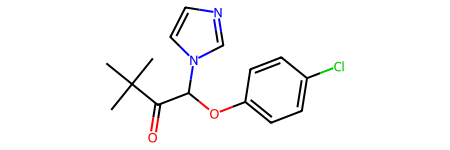

In [39]:
smiles = df_full.iloc[0]['SMILES']
mol = Chem.MolFromSmiles(smiles)
mol

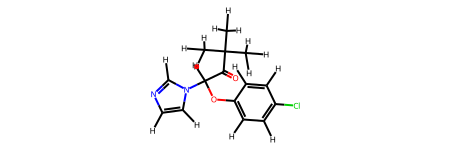

In [40]:
mol = Chem.AddHs(mol)
mol

In [41]:
mol.GetNumConformers()

0

In [42]:
params = AllChem.ETKDGv3() # Отдельный объект с параметрами
params.randomSeed = 0xf00d
params.numThreads = 4
params.pruneRmsThresh = 0.1
ids = AllChem.EmbedMultipleConfs(mol, 100, params)

In [43]:
mol.GetNumConformers() # ОЧЕНЬ ВАЖНО! СМОТРИМ ЧТО ПОМЕНЯЛОСЬ СОСТОЯНИЕ ОБЪЕКТА. ДАННЫЕ НЕ В ВЫВОДЕ 

43

In [60]:
ids

In [61]:
list(ids)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42]

In [64]:
dmat = AllChem.GetConformerRMSMatrix(mol, prealigned=False)
dmat

[2.0521247650412584,
 1.6178885149976778,
 2.325180071062092,
 2.274523255908097,
 1.408881204313561,
 1.9686218311030785,
 1.3405025206157668,
 2.341830910784199,
 1.168681330894877,
 2.0899596621647696,
 1.3414660448450066,
 2.408792647058581,
 1.1851867615647707,
 2.1996992562959665,
 0.9918901010768796,
 2.1378645504796636,
 1.9384487748058354,
 1.476575518263869,
 1.3683050938302361,
 1.7846875956912491,
 1.848200186871672,
 1.7934267316421542,
 1.94831060467653,
 2.0178431551871148,
 2.0475156911259758,
 1.842569106827859,
 1.8938569395552627,
 2.040508576310146,
 1.8779593482695267,
 2.462511885077488,
 1.5765198652102719,
 2.0482016285678903,
 1.4844453507371018,
 1.3862434124708645,
 1.9628598106018253,
 2.087513428479815,
 1.9162707381095438,
 1.2592706920661643,
 2.43555789327546,
 1.8119958881141622,
 2.2929774000812455,
 2.389064401419333,
 2.2854236781400608,
 1.8378078863926872,
 2.5936916748234986,
 1.1456097870103092,
 2.1336822000159006,
 1.7491907367177701,
 2.408811

In [63]:
AllChem.GetConformerRMSMatrix?

Signature: AllChem.GetConformerRMSMatrix(mol, atomIds=None, prealigned=False)
Docstring:
Returns the RMS matrix of the conformers of a molecule.
As a side-effect, the conformers will be aligned to the first
conformer (i.e. the reference) and will left in the aligned state.

Arguments:
  - mol:     the molecule
  - atomIds: (optional) list of atom ids to use a points for
             alingment - defaults to all atoms
  - prealigned: (optional) by default the conformers are assumed
                be unaligned and will therefore be aligned to the
                first conformer

Note that the returned RMS matrix is symmetrical, i.e. it is the
lower half of the matrix, e.g. for 5 conformers::

  rmsmatrix = [ a,
                b, c,
                d, e, f,
                g, h, i, j]

where a is the RMS between conformers 0 and 1, b is the RMS between
conformers 0 and 2, etc.
This way it can be directly used as distance matrix in e.g. Butina
clustering.
File:      ~/anaconda3/envs/p4env

In [65]:
clusters = Butina.ClusterData(dmat, mol.GetNumConformers(), 2.0, isDistData=True, reordering=True)
print("Number of clusters:", len(clusters))
print("Cluster sizes:", [len(c) for c in clusters])

Number of clusters: 3
Cluster sizes: [41, 14, 1]


In [46]:
clusters

((33, 1, 2, 10, 13, 15, 22, 29, 30, 32, 34, 36, 38, 40, 41),
 (39, 3, 5, 6, 11, 12, 18, 25, 27, 37, 42),
 (31, 0, 4, 9, 17, 21, 26),
 (24, 35, 7, 8, 16, 20, 23),
 (28,),
 (19,),
 (14,))

In [47]:
for ind, cluster in enumerate(clusters):
    block = Chem.MolToXYZBlock(mol, confId=cluster[0])
    with open(f"./data/conf_{ind:06}", "w") as w:
        w.write(block + "\n")

## Итоговое решение

In [48]:
# ======================
# Функции
# ======================

def gen_conformers(mol, numConfs=100, pruneRmsThresh=0.1):
    """Generate conformers with ETKDGv3"""
    params = AllChem.ETKDGv3()
    params.randomSeed = 0xf00d
    params.numThreads = 4
    params.pruneRmsThresh = pruneRmsThresh
    ids = AllChem.EmbedMultipleConfs(mol, numConfs, params)
    return list(ids)

def cluster_conformers(mol, threshold=2.0):
    """Cluster conformers with Butina using RMSD matrix"""
    dmat = AllChem.GetConformerRMSMatrix(mol, prealigned=False)
    clusters = Butina.ClusterData(
        dmat, mol.GetNumConformers(),
        threshold, isDistData=True, reordering=True
    )
    return clusters

def write_cluster_centroids(mol, clusters, prefix="./data/conf"):
    """Write one conformer per cluster to XYZ"""
    for ind, cluster in enumerate(clusters):
        block = Chem.MolToXYZBlock(mol, confId=cluster[0])
        with open(f"{prefix}_{ind:06}.xyz", "w") as w:
            w.write(block + "\n")

In [57]:
# ======================
# Основная петля для обработки данных
# ======================

df_full = pd.read_csv("summary.csv", index_col=0, nrows=50)  # reduce nrows for testing
df_full = df_full[df_full['CONFORMER id'] == 0]

for smiles in tqdm(df_full['SMILES']):
    try:
        mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
        conf_ids = gen_conformers(mol, numConfs=100)
        if not conf_ids:
            continue
        clusters = cluster_conformers(mol, threshold=2.0)
        write_cluster_centroids(mol, clusters, prefix=f"./data/{smiles.replace('/', '_')}")
    except Exception as e:
        print(f"Failed on {smiles}: {e}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:05<00:00,  2.51it/s]


## Дополнительно. Устройство RMS матрицы

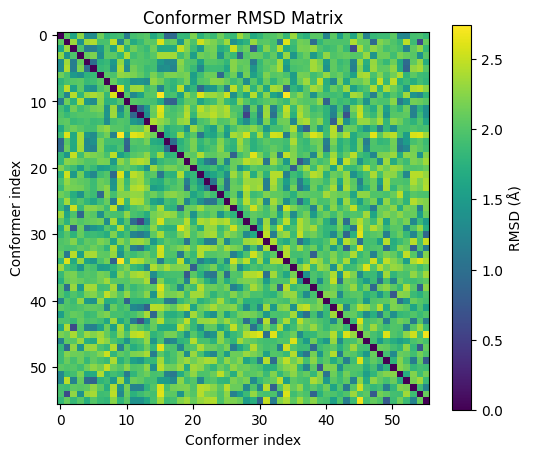

In [67]:
# Convert to full symmetric matrix
n = mol.GetNumConformers()
dmat_full = np.zeros((n, n))
k = 0
for i in range(1, n):
    for j in range(i):
        dmat_full[i, j] = dmat[k]
        dmat_full[j, i] = dmat[k]
        k += 1

# Plot heatmap
plt.figure(figsize=(6,5))
plt.imshow(dmat_full, cmap="viridis", interpolation="nearest")
plt.colorbar(label="RMSD (Å)")
plt.title("Conformer RMSD Matrix")
plt.xlabel("Conformer index")
plt.ylabel("Conformer index")
plt.show()

/home/kostanew/anaconda3/envs/p4env/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/kostanew/anaconda3/envs/p4env/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


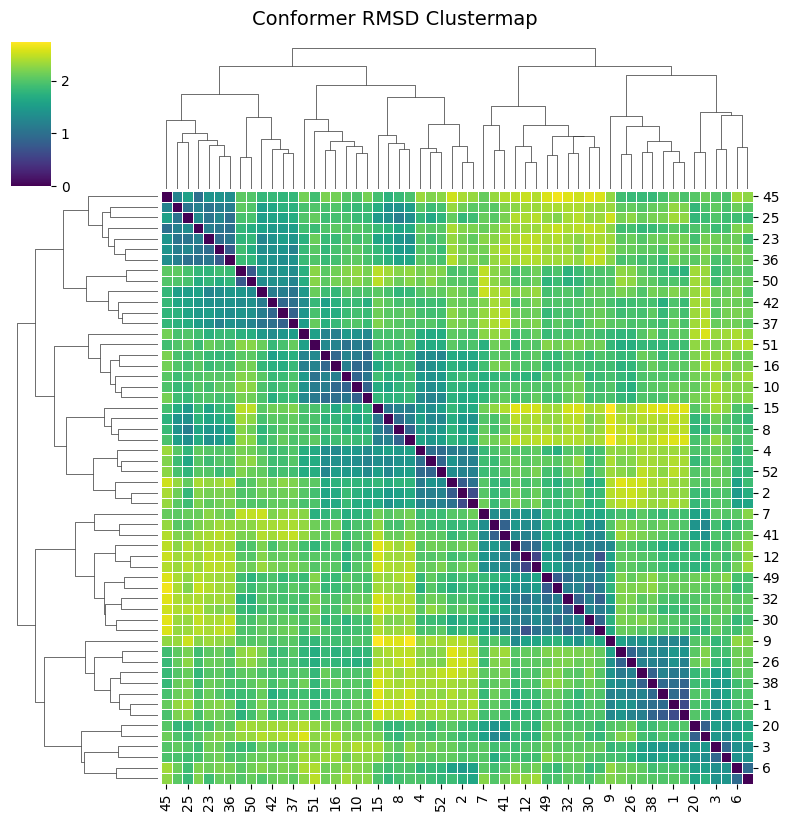

In [68]:
import seaborn as sns

# Use seaborn clustermap
sns.clustermap(
    dmat_full, 
    cmap="viridis", 
    linewidths=0.5,
    figsize=(8, 8),
    metric="euclidean",   # clustering metric
    method="average"      # linkage method
)

plt.suptitle("Conformer RMSD Clustermap", y=1.02, fontsize=14)
plt.show()